In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np
from math import sqrt, pi, log, e
from enum import Enum
import scipy.stats as stat
from scipy.stats import norm
import time



In [62]:
class BSMerton(object):
    def __init__(self, args):
        self.Type = int(args[0])  # 1 for a Call, - 1 for a put
        self.S = float(args[1])  # Underlying asset price
        self.K = float(args[2])  # Option strike K
        self.r = float(args[3])  # Continuous risk fee rate
        self.q = float(args[4])  # Dividend continuous rate
        self.T = float(args[5]) / 365.0  # Compute time to expiry
        self.sigma = float(args[6])  # Underlying volatility
        self.sigmaT = self.sigma * self.T ** 0.5  # sigma*T for reusability
        self.d1 = (log(self.S / self.K) + \
                   (self.r - self.q + 0.5 * (self.sigma ** 2)) \
                   * self.T) / self.sigmaT
        self.d2 = self.d1 - self.sigmaT
        [self.Premium] = self.premium()
        [self.Delta] = self.delta()
        [self.Theta] = self.theta()
        [self.Rho] = self.rho()
        [self.Vega] = self.vega()
        [self.Gamma] = self.gamma()
        [self.Phi] = self.phi()
        [self.Charm] = self.dDeltadTime()
        [self.Vanna] = self.dDeltadVol()

    def premium(self):
        tmpprem = self.Type * (self.S * e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1) - \
                               self.K * e ** (-self.r * self.T) * norm.cdf(self.Type * self.d2))
        return [tmpprem]

    ############################################
    ############ 1st order greeks ##############
    ############################################

    def delta(self):
        dfq = e ** (-self.q * self.T)
        if self.Type == 1:
            return [dfq * norm.cdf(self.d1)]
        else:
            return [dfq * (norm.cdf(self.d1) - 1)]

    # Vega for 1% change in vol
    def vega(self):
        return [0.01 * self.S * e ** (-self.q * self.T) * \
                norm.pdf(self.d1) * self.T ** 0.5]

    # Theta for 1 day change
    def theta(self):
        df = e ** -(self.r * self.T)
        dfq = e ** (-self.q * self.T)
        tmptheta = (1.0 / 365.0) \
                   * (-0.5 * self.S * dfq * norm.pdf(self.d1) * \
                      self.sigma / (self.T ** 0.5) + \
                      self.Type * (self.q * self.S * dfq * norm.cdf(self.Type * self.d1) \
                                   - self.r * self.K * df * norm.cdf(self.Type * self.d2)))
        return [tmptheta]

    def rho(self):
        df = e ** -(self.r * self.T)
        return [self.Type * self.K * self.T * df * 0.01 * norm.cdf(self.Type * self.d2)]

    def phi(self):
        return [0.01 * -self.Type * self.T * self.S * \
                e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1)]

    ############################################
    ############ 2nd order greeks ##############
    ############################################

    def gamma(self):
        return [e ** (-self.q * self.T) * norm.pdf(self.d1) / (self.S * self.sigmaT)]

    # Charm for 1 day change
    def dDeltadTime(self):
        dfq = e ** (-self.q * self.T)
        if self.Type == 1:
            return [
                (1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r - self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
                                        + (-self.q) * norm.cdf(self.d1))]
        else:
            return [
                (1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r - self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
                                        + self.q * norm.cdf(-self.d1))]

    # Vanna for 1% change in vol
    def dDeltadVol(self):
        return [0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)]

    # Vomma
    def dVegadVol(self):
        return [0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)]

In [63]:
class BSMertonImpledVolFinder(object):
    def __init__(self, args):
        self.Type = int(args[0])  # 1 for a Call, - 1 for a put
        self.S = float(args[1])  # Underlying asset price
        self.K = float(args[2])  # Option strike K
        self.r = float(args[3])  # Continuous risk fee rate
        self.q = float(args[4])  # Dividend continuous rate
        self.T = float(args[5]) / 365.0  # Compute time to expiry
        self.Premium = float(args[6])  # Option premium
        self.sigma = self.implied_volatility()

    def black_scholes_price(self, sigma):
        sigmaT = sigma * self.T ** 0.5
        d1 = (log(self.S / self.K) + (self.r - self.q + 0.5 * (sigma ** 2)) * self.T) / sigmaT
        d2 = d1 - sigmaT
        price = self.Type * (self.S * e ** (-self.q * self.T) * norm.cdf(self.Type * d1) - \
                             self.K * e ** (-self.r * self.T) * norm.cdf(self.Type * d2))
        return price

    def implied_volatility(self, epsilon=0.0001):
        # Use the bisection method to find the implied volatility that matches the given option premium
        lower = 0.001
        upper = 10.0
        mid = (lower + upper) / 2.0
        diff = self.Premium - self.black_scholes_price(mid)
        while abs(diff) > epsilon:
            if diff > 0:
                lower = mid
            else:
                upper = mid
            mid = (lower + upper) / 2.0
            diff = self.Premium - self.black_scholes_price(mid)
        return mid
    

In [64]:
# Call = 1  Put = -1   [Option,Price, Strike,Continuous rf rate, dividend, days to exp,vol]

Implied_Volatility = [.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,65,.7,.75,.8]

AAPL_Call= [1,165,165,0.0425,0.0053,14,Implied_Volatility]
AAPL_Put= [-1,165,165,0.0425,0.0053,14,Implied_Volatility]


def ArrayOfPricesGivenVols(OptionParams,IV_Array):
    prices = []
    for i in IV_Array:
        OptionParams[6] = i
        prices.append(BSMerton(OptionParams).Premium)
    return prices

AAPLCallSide= ArrayOfPricesGivenVols(AAPL_Call,Implied_Volatility)
AAPLPutSide= ArrayOfPricesGivenVols(AAPL_Put,Implied_Volatility)






In [79]:
AAPLPutSide

[1.173782017848609,
 1.8165913138241478,
 2.4599232051813402,
 3.103421072678273,
 3.746955662812084,
 4.390462753433198,
 5.033902524676748,
 5.677246009596956,
 6.320469673507574,
 6.9635529502028675,
 7.606477010470343,
 164.7312464770918,
 8.891777158342094,
 9.534119598064947,
 10.176235157940582]

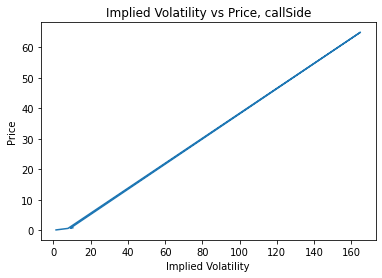

In [77]:
AAPLCallSide
plt.plot(AAPLCallSide, Implied_Volatility)
plt.xlabel('Implied Volatility')
plt.ylabel('Price')
plt.title('Implied Volatility vs Price, callSide')

plt.show()


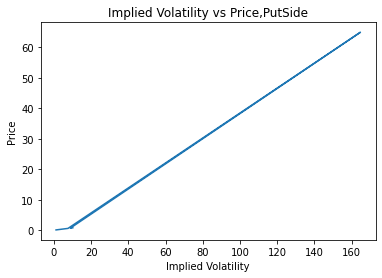

In [76]:
AAPLPutSide
plt.plot(AAPLPutSide, Implied_Volatility)
plt.xlabel('Implied Volatility')
plt.ylabel('Price')
plt.title('Implied Volatility vs Price,PutSide')

plt.show()


In [11]:
AAPL_Call_Sanity_Check = [1,151.03,165,0.0425,0.0053,33,.2]
BSMerton(AAPL_Call_Sanity_Check).Premium



0.3357989976315192

In [83]:
AAPL_Options = pd.read_csv("AAPL_Options.csv")
AAPL_Options.head()



,Stock,Expiration,Type,Strike,Last Price
0,AAPL,4/21/2023,Call,125,27.300
1,AAPL,4/21/2023,Call,130,22.575
2,AAPL,4/21/2023,Call,135,17.750
3,AAPL,4/21/2023,Call,140,13.850
4,AAPL,4/21/2023,Call,145,9.975


In [84]:
Strike = list(AAPL_Options.loc[0:10,"Strike"])

Strike_string =  ','.join(str(x) for x in Strike)
Strike_string

'125,130,135,140,145,150,155,160,165,170,175'

In [85]:
strike_list = list(AAPL_Options.loc[0:10,"Strike"])

In [86]:
Price = list(AAPL_Options.loc[0:10,"Last Price"])

Price_string = ','.join(str(x) for x in Price)



In [87]:
strike_list = list(AAPL_Options.loc[0:10,"Strike"])
strike_list_put = list(AAPL_Options.loc[11:21,"Strike"])
price_list = list(AAPL_Options.loc[0:10,"Last Price"])
price_list_put = list(AAPL_Options.loc[11:21,"Last Price"])

# ImpVolatility = ArrayOfVolsGivenPrices(AAPL_IV_Call, strike_list, price_list)


In [88]:
strike_list

[125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175]

In [89]:
strike_list_float_call = [float(strike) for strike in strike_list]
strike_list_float_put = [float(strike) for strike in strike_list_put]
price_list_float_call = [float(price) for price in price_list]
price_list_float_put = [float(price) for price in price_list_put]

In [90]:
strike_list_float_put

[125.0, 130.0, 135.0, 140.0, 145.0, 150.0, 155.0, 160.0, 165.0, 170.0, 175.0]

In [91]:


AAPL_IV_Call = [1,151.03,strike_list_float_call,0.0425,0.0053,49,price_list_float_call]
AAPL_IV_Put = [-1,151.03,strike_list_float_put,0.0425,0.0053,49,price_list_float_put]




#49 days




def ArrayOfVolsGivenPrices(OptionParams, strikes, prices):
    ImpVolatility = []
    for i in range(len(strikes)):
        OptionParams[2] = strikes[i]
        OptionParams[6] = prices[i]
        ImpVolatility.append(BSMertonImpledVolFinder(OptionParams).implied_volatility())
    return ImpVolatility


impVolatilityCallSide =ArrayOfVolsGivenPrices(AAPL_IV_Call,strike_list_float_call,price_list_float_call)
impVolatilityPutSide =ArrayOfVolsGivenPrices(AAPL_IV_Put,strike_list_float_put,price_list_float_put)

impVolatilityCallSide
impVolatilityPutSide

[0.3346000595092773,
 0.314479543685913,
 0.29777284049987784,
 0.28098985099792473,
 0.26753485202789307,
 0.25513832569122313,
 0.24241758251190182,
 0.2456978940963745,
 0.2734947204589844,
 0.29540796470642094,
 0.3612430553436279]

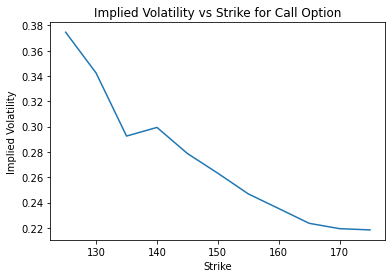

In [92]:
impVolatilityCallSide

#take values from Imp Volatility Call side and plot it on a graph
plt.plot(strike_list_float_call, impVolatilityCallSide)
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs Strike for Call Option')
plt.show()



In [95]:
impVolatilityCallSide

[0.3745931606292724,
 0.3423431205749511,
 0.29252815628051754,
 0.2993557815551757,
 0.2787394046783447,
 0.2631388530731201,
 0.2468278851509094,
 0.235237133026123,
 0.2235653266906738,
 0.2193314361572265,
 0.21833971405029293]

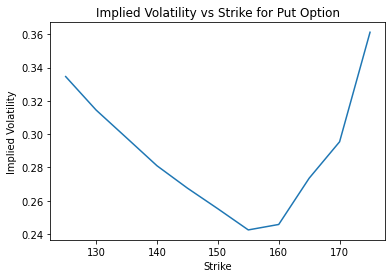

In [93]:
impVolatilityPutSide

#take values from Imp Volatility Put side and plot it on a graph
plt.plot(strike_list_float_put, impVolatilityPutSide)
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs Strike for Put Option')
plt.show()


In [94]:
impVolatilityPutSide


[0.3346000595092773,
 0.314479543685913,
 0.29777284049987784,
 0.28098985099792473,
 0.26753485202789307,
 0.25513832569122313,
 0.24241758251190182,
 0.2456978940963745,
 0.2734947204589844,
 0.29540796470642094,
 0.3612430553436279]

In [2]:
Dailyreturns = pd.read_csv("DailyPrices.csv")
Option_Portfolio = pd.read_csv("problem3.csv",parse_dates=["ExpirationDate"])
Option_Portfolio.head()

,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice
0,Straddle,Option,AAPL,1,Call,2023-04-21,150.0,6.80
1,Straddle,Option,AAPL,1,Put,2023-04-21,150.0,4.85
2,SynLong,Option,AAPL,1,Call,2023-04-21,150.0,6.80
3,SynLong,Option,AAPL,-1,Put,2023-04-21,150.0,4.85
4,CallSpread,Option,AAPL,1,Call,2023-04-21,150.0,6.80


In [1]:

import pandas as pd
import numpy as np
import sklearn
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from scipy.stats import describe
from scipy.stats import norm
from scipy.stats import kurtosis
from scipy.stats import t
from scipy.stats import multivariate_t
from scipy.integrate import quad
from scipy.stats.mstats import gmean
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import scipy.linalg
import pprint as pprint
import time as time
from sklearn.decomposition import PCA
import datetime as dt
from numpy.linalg import eig
import QuantRiskTools as QRT


In [9]:
Dailyreturns = Dailyreturns.drop(Dailyreturns.columns[0], axis=1)
DailyReturns = QRT.calculateReturns(Dailyreturns, "Geometric")
DailyReturns.head()


,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,BRK-B,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
1,0.016127,2.315237e-02,0.018542,0.008658,0.053291,0.007987,0.008319,0.015158,0.091812,0.006109,...,0.012807,-0.004082,0.004592,0.052344,0.003600,-0.012275,0.033021,0.026240,0.028572,0.013237
2,0.017266,2.173132e-02,0.017353,0.018905,0.054387,0.016322,0.016168,-0.005328,0.092471,0.004359,...,0.019651,-0.006501,0.010381,0.093259,0.012927,-0.000181,0.036494,0.041942,0.027143,-0.013090
3,-0.004464,2.220446e-16,-0.012437,-0.003316,0.000674,-0.022040,-0.022110,-0.045889,0.009890,-0.002323,...,-0.015985,-0.001210,0.025554,0.041889,0.002946,0.004651,0.004512,0.008678,-0.007143,-0.041477
4,-0.010911,-9.355810e-03,-0.021948,-0.016534,-0.021444,-0.037801,-0.035717,-0.053009,-0.025755,0.001655,...,-0.016620,-0.002117,0.032941,0.041434,-0.000982,-0.001318,-0.009223,0.004132,-0.010794,-0.027063
5,-0.021525,-2.700144e-02,-0.022661,-0.032027,-0.061923,-0.042151,-0.043588,-0.071750,-0.036140,-0.000382,...,-0.007284,0.004989,0.023757,0.044811,-0.002127,-0.001990,-0.000958,-0.033678,-0.013016,-0.040300


In [10]:
AAPLReturns = DailyReturns["AAPL"]
AAPLReturns
AAPLMean =AAPLReturns.mean()
DailyReturnsAAPLMeansRemoved = AAPLReturns - AAPLMean

DailyReturnsAAPLMeansRemoved= DailyReturnsAAPLMeansRemoved.dropna()

DailyReturnsAAPLMeansRemoved.tail()

244    0.021298
245    0.004821
246    0.022190
247    0.005951
248   -0.000294
Name: AAPL, dtype: float64

In [2]:

dailyPrices = pd.read_csv("DailyPrices.csv")
# Calculate the log returns of AAPL
aapl_log_returns = np.log(dailyPrices['AAPL']/dailyPrices['AAPL'].shift(1))
# Demean the series so there is 0 mean
aapl_log_returns = aapl_log_returns-aapl_log_returns.mean()
AAPL_ARIMA_Model= sm.tsa.ARIMA(aapl_log_returns,order=(1,0,0))
modelOutput = AAPL_ARIMA_Model.fit()
modelOutput.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   AAPL   No. Observations:                  249
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 590.665
Date:                Sun, 26 Mar 2023   AIC                          -1175.329
Time:                        01:06:15   BIC                          -1164.777
Sample:                             0   HQIC                         -1171.082
                                - 249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.33e-06      0.001     -0.001      0.999      -0.003       0.003
ar.L1         -0.0468      0.063     -0.742      0.458      -0.171       0.077
sigma2         0.0005   4.31e-05     11.595      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.75
Prob(Q):                              0.95   Prob(JB):                         0.25
Heteroskedasticity (H):               0.96   Skew:                             0.03
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:

Option_Portfolio
# current_date = 3/3/2023
# Expiration_Date = Option_Portfolio["ExpirationDate"]
# Expiration_Date


,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice
0,Straddle,Option,AAPL,1,Call,2023-04-21,150.0,6.80
1,Straddle,Option,AAPL,1,Put,2023-04-21,150.0,4.85
2,SynLong,Option,AAPL,1,Call,2023-04-21,150.0,6.80
3,SynLong,Option,AAPL,-1,Put,2023-04-21,150.0,4.85
4,CallSpread,Option,AAPL,1,Call,2023-04-21,150.0,6.80
5,CallSpread,Option,AAPL,-1,Call,2023-04-21,160.0,2.21
6,PutSpread,Option,AAPL,1,Put,2023-04-21,150.0,4.85
7,PutSpread,Option,AAPL,-1,Put,2023-04-21,140.0,1.84
8,Stock,Stock,AAPL,1,NaN,NaT,NaN,151.03
9,Call,Option,AAPL,1,Call,2023-04-21,150.0,6.80


In [24]:
#make an array of implied volatility for optionPortfolio for Strike

Option_Portfolio_Strike = list(Option_Portfolio.loc[0:10,"Strike"])
Option_Portfolio_Strike_float = [float(strike) for strike in Option_Portfolio_Strike]
Option_Portfolio_Strike_float


[150.0, 150.0, 150.0, 150.0, 150.0, 160.0, 150.0, 140.0, nan, 150.0, 150.0]

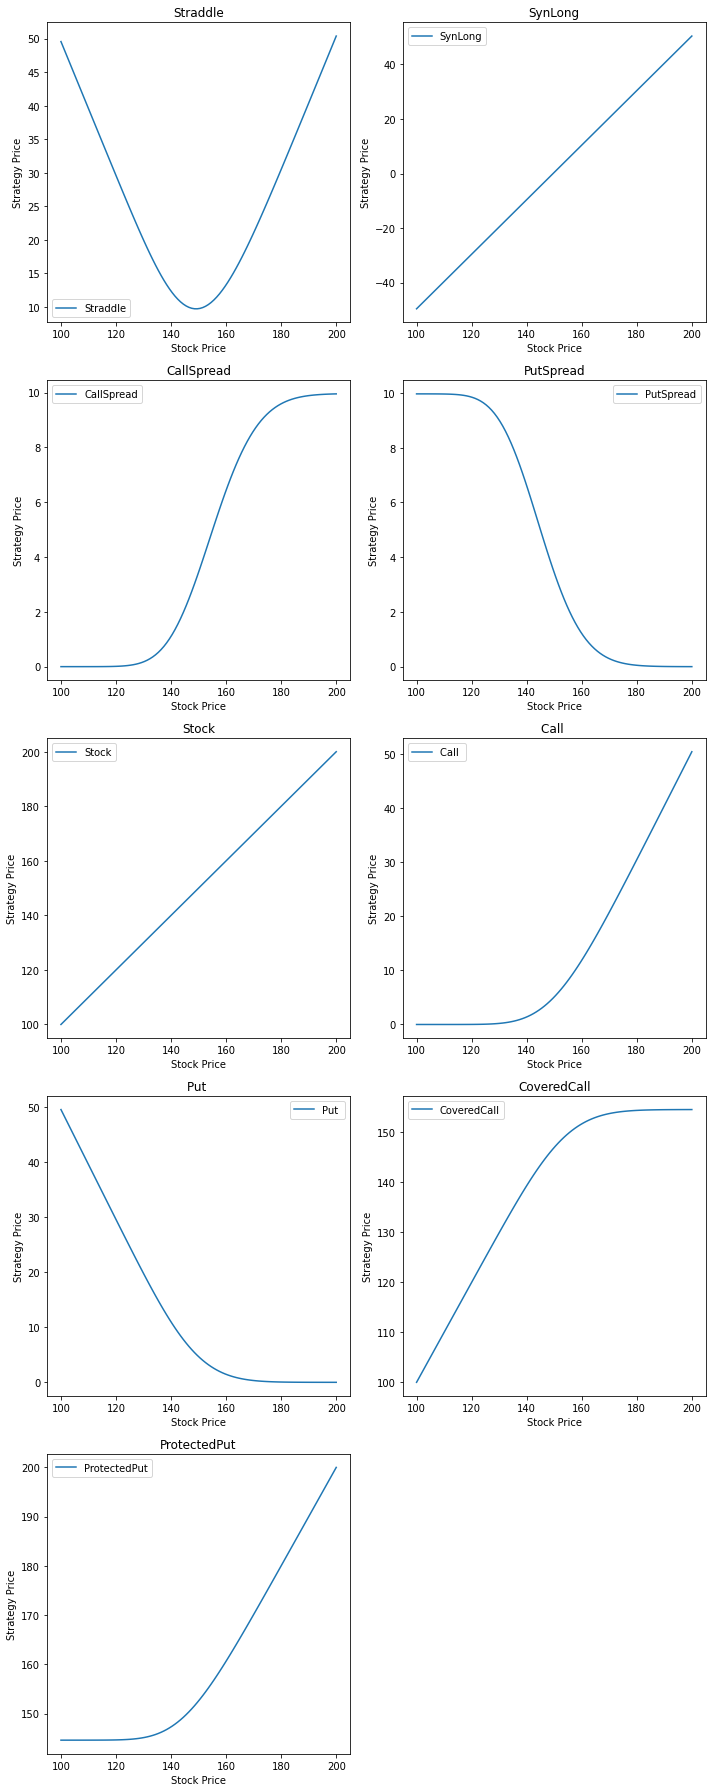

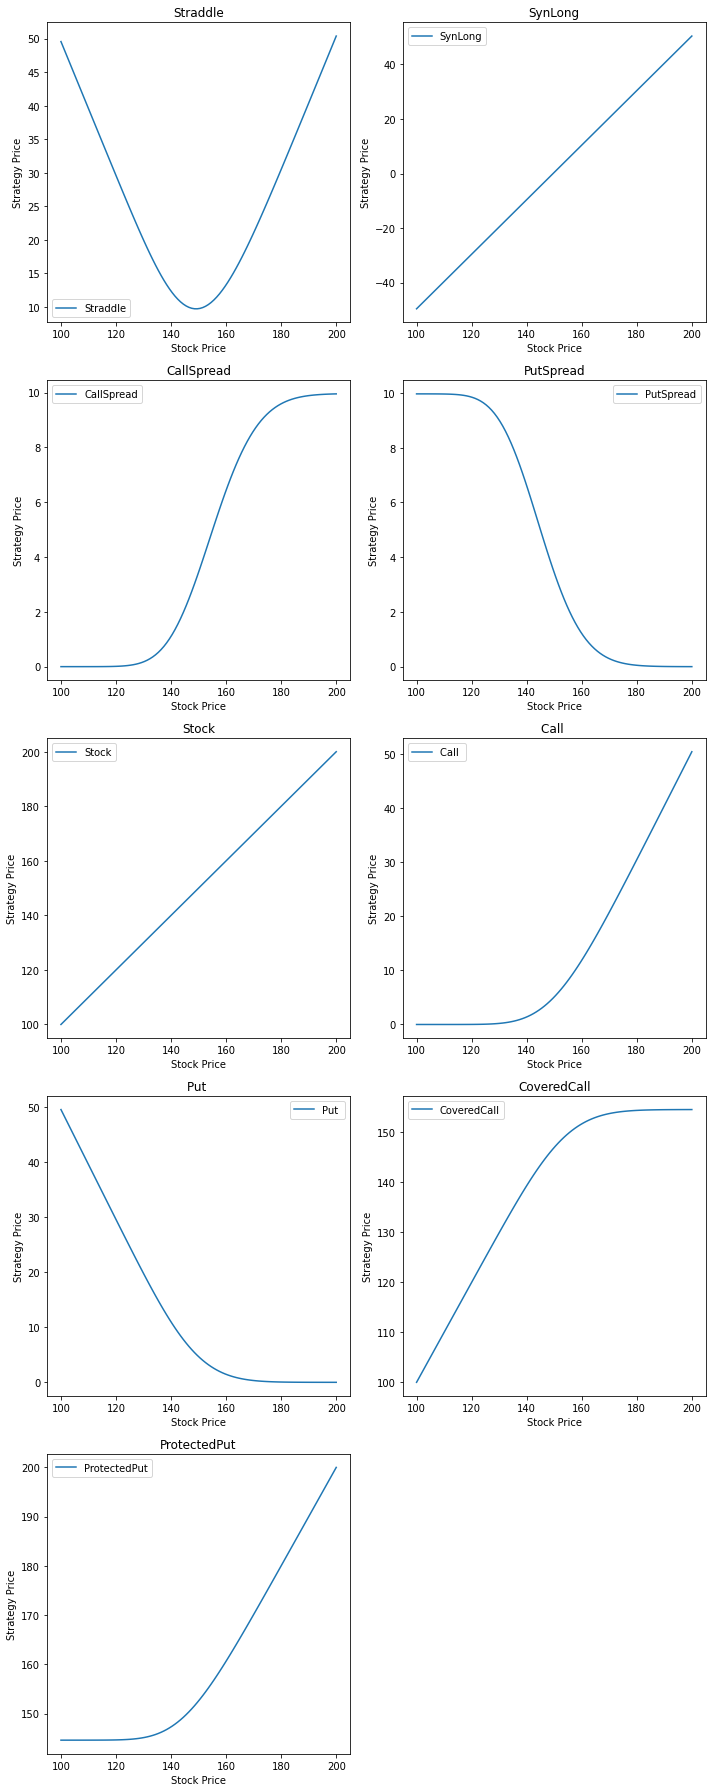

In [18]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

class BSMerton:
    def __init__(self, S, r, q, sigma):
        self.S = S
        self.r = r
        self.q = q
        self.sigma = sigma

    def call(self, K, T):
        d1 = (np.log(self.S / K) + (self.r - self.q + 0.5 * self.sigma ** 2) * T) / (self.sigma * np.sqrt(T))
        d2 = d1 - self.sigma * np.sqrt(T)
        return self.S * np.exp(-self.q * T) * norm.cdf(d1) - K * np.exp(-self.r * T) * norm.cdf(d2)

    def put(self, K, T):
        d1 = (np.log(self.S / K) + (self.r - self.q + 0.5 * self.sigma ** 2) * T) / (self.sigma * np.sqrt(T))
        d2 = d1 - self.sigma * np.sqrt(T)
        return K * np.exp(-self.r * T) * norm.cdf(-d2) - self.S * np.exp(-self.q * T) * norm.cdf(-d1)

def plot_strategy_prices(df, r, q, sigma, current_date, strategies):
    S = np.linspace(100, 200, 100)
    T = (pd.to_datetime(df['ExpirationDate']) - pd.to_datetime(current_date)).dt.days / 365

    n_strategies = len(strategies)
    ncols = 2
    nrows = math.ceil(n_strategies / ncols)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5 * nrows))
    axes = axes.flatten()
    
    for idx, strategy in enumerate(strategies):
        strat_df = df[df['Portfolio'] == strategy]
        total_price = np.zeros_like(S)

        for _, row in strat_df.iterrows():
            if row['Type'] == 'Option':
                K = row['Strike']
                t = T.loc[row.name]
                option_type = row['OptionType']
                holding = row['Holding']

                bsmerton = BSMerton(S, r, q, sigma)

                if option_type == 'Call':
                    price = bsmerton.call(K, t)
                elif option_type == 'Put':
                    price = bsmerton.put(K, t)
                    
                total_price += holding * price

            elif row['Type'] == 'Stock':
                holding = row['Holding']
                total_price += holding * S

        axes[idx].plot(S, total_price, label=strategy)
        axes[idx].set_title(strategy)
        axes[idx].set_xlabel('Stock Price')
        axes[idx].set_ylabel('Strategy Price')
        axes[idx].legend()

    for idx in range(n_strategies, nrows * ncols):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

csv_file = 'problem3.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_file)  # Default delimiter is ','

r = 0.0425  # Continuous risk-free rate
q = 0.0053  # Dividend continuous rate
sigma = 0.3  # Volatility
current_date = '2023-03-25'

strategies = df['Portfolio'].unique()
plot_strategy_prices(df, r, q, sigma, current_date, strategies)


csv_file = 'problem3.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_file)  # Default delimiter is ','

r = 0.0425  # Continuous risk-free rate
q = 0.0053  # Dividend continuous rate
sigma = 0.3  # Volatility
current_date = '2023-03-25'

strategies = df['Portfolio'].unique()
plot_strategy_prices(df, r, q, sigma, current_date, strategies)


In [47]:
DailyReturnsAAPLMeansRemoved
prices_df = np.exp(DailyReturnsAAPLMeansRemoved.cumsum())
prices_df


,AAPL
1,1.133670
2,1.283383
3,1.421635
4,1.560116
5,1.682140
...,...
244,0.967860
245,0.972537
246,0.994359
247,1.000294


In [20]:
dailyPrices = pd.read_csv("DailyPrices.csv")
# Calculate the log returns of AAPL
aapl_log_returns = np.log(dailyPrices['AAPL']/dailyPrices['AAPL'].shift(1))
# Demean the series so there is 0 mean
aapl_log_returns = aapl_log_returns-aapl_log_returns.mean()

In [21]:
dailyPrices['AAPL'][-1:]

248    150.639999
Name: AAPL, dtype: float64

In [58]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
class BSMerton(object):
    def __init__(self, args):
        self.Type = int(args[0])  # 1 for a Call, - 1 for a put
        self.S = float(args[1])  # Underlying asset price
        self.K = float(args[2])  # Option strike K
        self.r = float(args[3])  # Continuous risk fee rate
        self.q = float(args[4])  # Dividend continuous rate
        self.T = float(args[5]) / 365.0  # Compute time to expiry
        self.sigma = float(args[6])  # Underlying volatility
        self.sigmaT = self.sigma * self.T ** 0.5  # sigma*T for reusability
        self.d1 = (log(self.S / self.K) + \
                   (self.r - self.q + 0.5 * (self.sigma ** 2)) \
                   * self.T) / self.sigmaT
        self.d2 = self.d1 - self.sigmaT
        [self.Premium] = self.premium()
        [self.Delta] = self.delta()
        [self.Theta] = self.theta()
        [self.Rho] = self.rho()
        [self.Vega] = self.vega()
        [self.Gamma] = self.gamma()
        [self.Phi] = self.phi()
        [self.Charm] = self.dDeltadTime()
        [self.Vanna] = self.dDeltadVol()

    def premium(self):
        tmpprem = self.Type * (self.S * e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1) - \
                               self.K * e ** (-self.r * self.T) * norm.cdf(self.Type * self.d2))
        return [tmpprem]

    ############################################
    ############ 1st order greeks ##############
    ############################################

    def delta(self):
        dfq = e ** (-self.q * self.T)
        if self.Type == 1:
            return [dfq * norm.cdf(self.d1)]
        else:
            return [dfq * (norm.cdf(self.d1) - 1)]

    # Vega for 1% change in vol
    def vega(self):
        return [0.01 * self.S * e ** (-self.q * self.T) * \
                norm.pdf(self.d1) * self.T ** 0.5]

    # Theta for 1 day change
    def theta(self):
        df = e ** -(self.r * self.T)
        dfq = e ** (-self.q * self.T)
        tmptheta = (1.0 / 365.0) \
                   * (-0.5 * self.S * dfq * norm.pdf(self.d1) * \
                      self.sigma / (self.T ** 0.5) + \
                      self.Type * (self.q * self.S * dfq * norm.cdf(self.Type * self.d1) \
                                   - self.r * self.K * df * norm.cdf(self.Type * self.d2)))
        return [tmptheta]

    def rho(self):
        df = e ** -(self.r * self.T)
        return [self.Type * self.K * self.T * df * 0.01 * norm.cdf(self.Type * self.d2)]

    def phi(self):
        return [0.01 * -self.Type * self.T * self.S * \
                e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1)]

    ############################################
    ############ 2nd order greeks ##############
    ############################################

    def gamma(self):
        return [e ** (-self.q * self.T) * norm.pdf(self.d1) / (self.S * self.sigmaT)]

    # Charm for 1 day change
    def dDeltadTime(self):
        dfq = e ** (-self.q * self.T)
        if self.Type == 1:
            return [
                (1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r - self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
                                        + (-self.q) * norm.cdf(self.d1))]
        else:
            return [
                (1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r - self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
                                        + self.q * norm.cdf(-self.d1))]

    # Vanna for 1% change in vol
    def dDeltadVol(self):
        return [0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)]

    # Vomma
    def dVegadVol(self):
        return [0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)]
    

def Arima_sim(returns, ndays, p0, nsim=10000, seed=10):
    Arima_Fit = sm.tsa.arima.ARIMA(returns, order=(1, 0, 0))
    constant, beta, sigma = Arima_Fit.fit().params[0], Arima_Fit.fit().params[1], np.sqrt(Arima_Fit.fit().params[2])
    np.random.seed(seed)
    rsim = np.zeros((nsim, ndays))
    
    for i in range(nsim):
        rsim[i, 0] = constant + beta * returns.iloc[-1] + sigma * np.random.normal()
        for j in range(1, ndays):
            rsim[i, j] = constant + beta * rsim[i, j - 1] + sigma * np.random.normal()
    
    rsim_cum = np.sum(rsim, axis=1)
    pricesim = np.zeros(nsim)
    
    for i in range(nsim):
        pricesim[i] = max(p0 * np.exp(rsim_cum[i]), 0.01)
    
    return pd.DataFrame(pricesim)


prices = Arima_sim(aapl_log_returns, 10, dailyPrices['AAPL'].iloc[-1], seed=525600)

def calculate_portfolio_values(prices, port_options, r, q, sigma, days_to_expiry):
    if not isinstance(prices, pd.DataFrame):
        prices = pd.DataFrame(prices, columns=['Price'])

   
   
    def option_type_to_int(option_type):
        return 1 if option_type == 'Call' else -1

    pl_list = []
    for price in prices:
        print(port_options.apply(lambda row: option_type_to_int(row['OptionType']), axis=1))
        pl_list.append(pl)
    return pd.concat(pl_list, axis=1)

# def calculate_portfolio_values(prices, port_options, r, q, sigma, days_to_expiry):
#     print("Prices:")
#     print(prices)
#     print("Port Options:")
#     print(port_options)
#     print("r:", r, "q:", q, "sigma:", sigma)
    
#     pl_list = []
#     for price in prices:
#         pl = port_options.apply(lambda row: BSMerton([option_type_to_int(row['OptionType']), price, row['Strike'], r, q, days_to_expiry, sigma]).Premium * row['Holding'] if row['Type'] == 'Option' else (price - row['CurrentPrice']) * row['Holding'], axis=1)
#         pl_list.append(pl)
#     return pd.concat(pl_list, axis=1)


def calculate_portfolio_statistics(portfolio_values):
    mean = portfolio_values.mean(axis=0)
    var = np.percentile(portfolio_values, 5, axis=0)
    es = portfolio_values[portfolio_values <= var].mean(axis=0)
    return pd.DataFrame({'Mean': mean, 'VaR': var, 'ES': es})




In [48]:
calculate_portfolio_values

<function __main__.calculate_portfolio_values(prices, port_options, r, q, sigma, days_to_expiry)>

In [59]:
# Load your data
dailyPrices = pd.read_csv("DailyPrices.csv")
aapl_log_returns = np.log(dailyPrices['AAPL']/dailyPrices['AAPL'].shift(1))
aapl_log_returns = aapl_log_returns - aapl_log_returns.mean()

file_path = 'problem3.csv'
df = pd.read_csv(file_path)

# Filter out the stock positions
port_options = df[df['Type'] == 'Option'].copy()

# Calculate the stock price from the stock positions
underlying = df.loc[df['Type'] == 'Stock', 'CurrentPrice'].iloc[0]

# Set parameters
ndays = 10
p0 = dailyPrices['AAPL'].iloc[-1]
r = 0.0425
q = 0.0052
sigma = 0.25

# Call Arima_sim to get simulated prices
prices = Arima_sim(aapl_log_returns, ndays, p0)

prices = prices.values

# Call calculate_portfolio_values with the simulated prices and your port_options DataFrame
portfolio_values = calculate_portfolio_values(prices, port_options, r, q, sigma, ndays)

# Set the index for the portfolio_values DataFrame
portfolio_values.set_index(port_options['Portfolio'], inplace=True)
portfolio_values = portfolio_values.groupby(level=0).sum().T

# Call calculate_portfolio_statistics with the portfolio_values DataFrame
portfolio_statistics = calculate_portfolio_statistics(portfolio_values)

# Print the results
print(portfolio_statistics)


0     1
1    -1
2     1
3    -1
4     1
5     1
6    -1
7    -1
9     1
10   -1
12    1
14   -1
dtype: int64


NameError: name 'pl' is not defined

In [34]:
dailyPrices = pd.read_csv("DailyPrices.csv")
aapl_log_returns = np.log(dailyPrices['AAPL']/dailyPrices['AAPL'].shift(1))
aapl_log_returns = aapl_log_returns - aapl_log_returns.mean()

print(dailyPrices)

               Date         SPY        AAPL        MSFT        AMZN  \
0    2/14/2022 0:00  432.011322  167.863144  292.261475  155.167007   
1    2/15/2022 0:00  438.978333  171.749573  297.680664  156.510498   
2    2/16/2022 0:00  439.470337  171.511032  297.333191  158.100494   
3    2/17/2022 0:00  430.082642  167.863144  288.626679  154.652496   
4    2/18/2022 0:00  427.297852  166.292648  285.846893  152.601502   
..              ...         ...         ...         ...         ...   
244   2/3/2023 0:00  412.350006  154.264465  258.350006  103.389999   
245   2/6/2023 0:00  409.829987  151.498688  256.769989  102.180000   
246   2/7/2023 0:00  415.190002  154.414230  267.559998  102.110001   
247   2/8/2023 0:00  410.649994  151.688400  266.730011  100.050003   
248   2/9/2023 0:00  407.089996  150.639999  263.619995   98.239998   

           TSLA       GOOGL        GOOG        META        NVDA  ...  \
0    291.920013  135.526001  135.300003  217.699997  242.443298  ...   
1  

In [36]:
# calculate a 10 day Implied Volatility and create a volatility smile
prices= pd.DataFrame(prices)
prices.columns = ['Price']
prices


,Price
0,152.591830
1,156.327003
2,162.703151
3,153.584000
4,145.142827
...,...
9995,160.852372
9996,165.022145
9997,151.567658
9998,154.629563


In [26]:
def simulate_stock_prices_arima_ar1(model_output, num_days, initial_stock_price):
    alpha = model_output.params[1]
    sigma = np.sqrt(model_output.params[2])

    simulated_log_returns = np.zeros(num_days)
    simulated_log_returns[0] = alpha + sigma * np.random.normal()

    for t in range(1, num_days):
        simulated_log_returns[t] = alpha + model_output.params[0] * simulated_log_returns[t - 1] + sigma * np.random.normal()

    simulated_stock_prices = initial_stock_price * np.exp(np.cumsum(simulated_log_returns))
    return simulated_stock_prices


import numpy as np



def options_strategy_prices(stock_prices, df, r, q, current_date):
    strategy_prices = np.zeros_like(stock_prices)
    df_filtered = df[df['Portfolio'] == "CallSpread"]

    for _, row in df_filtered.iterrows():
        if row['Type'] == 'Option':
            for idx, stock_price in enumerate(stock_prices):
                option_price = get_option_price(row, stock_price, r, q, current_date)
                strategy_prices[idx] += row['Holding'] * option_price
        elif row['Type'] == 'Stock':
            strategy_prices += row['Holding'] * stock_prices
            
    return strategy_prices

def compute_mean_var_and_expected_shortfall(strategy_prices, alpha=0.05):
    sorted_strategy_prices = np.sort(strategy_prices)
    index = int(alpha * len(sorted_strategy_prices))
    mean_var = sorted_strategy_prices[index]
    expected_shortfall = sorted_strategy_prices[:index].mean()
    return mean_var, expected_shortfall

def simulate_arima_and_calculate_risk_metrics(model_output, num_days, initial_stock_price, df, r, q, current_date):
    simulated_stock_prices = simulate_stock_prices_arima_ar1(model_output, num_days, initial_stock_price)
    strategy_prices = options_strategy_prices(simulated_stock_prices, df, r, q, current_date)
    mean_var, expected_shortfall = compute_mean_var_and_expected_shortfall(strategy_prices)
    return mean_var, expected_shortfall

# Use the following code to test the function
mean_var, expected_shortfall = simulate_arima_and_calculate_risk_metrics(modelOutput, 10, 150, df, r, q, current_date)
print("Mean VaR:", mean_var)
print("Expected Shortfall:", expected_shortfall)


Mean VaR: 4.589999999999762
Expected Shortfall: nan


c:\Users\Moneybag Mike\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Moneybag Mike\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice.
c:\Users\Moneybag Mike\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
####################################################################################################################################
#
#                                  ORIGINAL WORKING-ISH CODE THAT WORKED BEFORE TRYING TO GET VAR TO WORK
#                                                               DO NOT TOUCH 
#
#
####################################################################################################################################


# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from math import log, e
# from scipy.stats import norm

# # Add the given BSMerton and BSMertonImpledVolFinder classes here
# class BSMerton(object):
#     def __init__(self, args):
#         self.Type = int(args[0])  # 1 for a Call, - 1 for a put
#         self.S = float(args[1])  # Underlying asset price
#         self.K = float(args[2])  # Option strike K
#         self.r = float(args[3])  # Continuous risk fee rate
#         self.q = float(args[4])  # Dividend continuous rate
#         self.T = float(args[5]) / 365.0  # Compute time to expiry
#         self.sigma = float(args[6])  # Underlying volatility
#         self.sigmaT = self.sigma * self.T ** 0.5  # sigma*T for reusability
#         self.d1 = (log(self.S / self.K) + \
#                    (self.r - self.q + 0.5 * (self.sigma ** 2)) \
#                    * self.T) / self.sigmaT
#         self.d2 = self.d1 - self.sigmaT
#         [self.Premium] = self.premium()
#         [self.Delta] = self.delta()
#         [self.Theta] = self.theta()
#         [self.Rho] = self.rho()
#         [self.Vega] = self.vega()
#         [self.Gamma] = self.gamma()
#         [self.Phi] = self.phi()
#         [self.Charm] = self.dDeltadTime()
#         [self.Vanna] = self.dDeltadVol()

#     def premium(self):
#         tmpprem = self.Type * (self.S * e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1) - \
#                                self.K * e ** (-self.r * self.T) * norm.cdf(self.Type * self.d2))
#         return [tmpprem]

#     ############################################
#     ############ 1st order greeks ##############
#     ############################################

#     def delta(self):
#         dfq = e ** (-self.q * self.T)
#         if self.Type == 1:
#             return [dfq * norm.cdf(self.d1)]
#         else:
#             return [dfq * (norm.cdf(self.d1) - 1)]

#     # Vega for 1% change in vol
#     def vega(self):
#         return [0.01 * self.S * e ** (-self.q * self.T) * \
#                 norm.pdf(self.d1) * self.T ** 0.5]

#     # Theta for 1 day change
#     def theta(self):
#         df = e ** -(self.r * self.T)
#         dfq = e ** (-self.q * self.T)
#         tmptheta = (1.0 / 365.0) \
#                    * (-0.5 * self.S * dfq * norm.pdf(self.d1) * \
#                       self.sigma / (self.T ** 0.5) + \
#                       self.Type * (self.q * self.S * dfq * norm.cdf(self.Type * self.d1) \
#                                    - self.r * self.K * df * norm.cdf(self.Type * self.d2)))
#         return [tmptheta]

#     def rho(self):
#         df = e ** -(self.r * self.T)
#         return [self.Type * self.K * self.T * df * 0.01 * norm.cdf(self.Type * self.d2)]

#     def phi(self):
#         return [0.01 * -self.Type * self.T * self.S * \
#                 e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1)]

#     ############################################
#     ############ 2nd order greeks ##############
#     ############################################

#     def gamma(self):
#         return [e ** (-self.q * self.T) * norm.pdf(self.d1) / (self.S * self.sigmaT)]

#     # Charm for 1 day change
#     def dDeltadTime(self):
#         dfq = e ** (-self.q * self.T)
#         if self.Type == 1:
#             return [
#                 (1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r - self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
#                                         + (-self.q) * norm.cdf(self.d1))]
#         else:
#             return [
#                 (1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r - self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
#                                         + self.q * norm.cdf(-self.d1))]

#     # Vanna for 1% change in vol
#     def dDeltadVol(self):
#         return [0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)]

#     # Vomma
#     def dVegadVol(self):
#         return [0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)]
    

# from scipy.optimize import fsolve

# class BSMertonImpledVolFinder(object):
#     def __init__(self, args):
#         self.Type = int(args[0])  # 1 for a Call, -1 for a put
#         self.S = float(args[1])  # Underlying asset price
#         self.K = float(args[2])  # Option strike K
#         self.r = float(args[3])  # Continuous risk-free rate
#         self.q = float(args[4])  # Dividend continuous rate
#         self.T = float(args[5]) / 365.0  # Compute time to expiry
#         self.Premium = float(args[6])  # Option premium
#         self.sigma = self.implied_volatility()

#     def black_scholes_price(self, sigma):
#         sigmaT = sigma * self.T ** 0.5
#         d1 = (log(self.S / self.K) + (self.r - self.q + 0.5 * (sigma ** 2)) * self.T) / sigmaT
#         d2 = d1 - sigmaT
#         price = self.Type * (self.S * e ** (-self.q * self.T) * norm.cdf(self.Type * d1) - \
#                              self.K * e ** (-self.r * self.T) * norm.cdf(self.Type * d2))
#         return price

#     def option_price_difference(self, sigma):
#         return self.Premium - self.black_scholes_price(sigma)

#     def implied_volatility(self):
#         initial_guess = 0.2
#         result = fsolve(self.option_price_difference, initial_guess)
#         return result[0]




# # Helper function to get the option price for different strategies
# def get_option_price(option_data, stock_price, r, q, current_date):
#     T = (pd.to_datetime(option_data['ExpirationDate']) - pd.to_datetime(current_date)).days
#     option_type = 1 if option_data['OptionType'] == 'Call' else -1
#     option_args = [option_type, stock_price, option_data['Strike'], r, q, T, option_data['CurrentPrice']]
#     implied_vol = BSMertonImpledVolFinder(option_args).sigma
#     option_args_with_vol = option_args[:-1] + [implied_vol]
#     bsmerton = BSMerton(option_args_with_vol)
#     option_price = bsmerton.Premium  #Console log
#     print(option_price)  # Console log
#     return bsmerton.Premium


# # Function to plot the price of the strategies
# def plot_strategy_prices(df, r, q, current_date, selected_strategy):
#     stock_prices = np.linspace(140, 165, 20)
#     strategy_prices = {selected_strategy: np.zeros_like(stock_prices)}

#     df_filtered = df[df['Portfolio'] == selected_strategy]

#     for _, row in df_filtered.iterrows():
#         strategy = row['Portfolio']
#         if row['Type'] == 'Option':
#             for idx, stock_price in enumerate(stock_prices):
#                 option_price = get_option_price(row, stock_price, r, q, current_date)
#                 strategy_prices[strategy][idx] += row['Holding'] * option_price
#         elif row['Type'] == 'Stock':
#             strategy_prices[strategy] += row['Holding'] * stock_prices

#     for strategy, prices in strategy_prices.items():
#         plt.plot(stock_prices, prices, label=strategy)

#     plt.legend()
#     plt.xlabel("Stock Price")
#     plt.ylabel("Strategy Price")
#     plt.title("Strategy Prices Across Stock Prices")
#     plt.show()

# # Example usage
# csv_file = 'problem3.csv'  # Replace with your CSV file path
# df = pd.read_csv(csv_file, delimiter=',')  # Assuming your CSV uses tab as a delimiter

# r = 0.0425  # Continuous risk-free rate
# q = 0.0053  # Dividend continuous rate
# current_date = '2023-03-25'

# plot_strategy_prices(df, r, q, current_date,"CallSpread")